pygame 2.1.2 (SDL 2.26.5, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html
audio usb connected


Authorization required, but no authorization protocol specified



ToggleButton(value=False, button_style='danger', description='Stop', icon='square')

/dev/ttyACM* connected succeed


[0:36:23.603086386] [4999]  INFO Camera camera_manager.cpp:330 libcamera v0.5.2+99-bfd68f78
[0:36:23.626242110] [5060]  INFO IPAProxy ipa_proxy.cpp:180 Using tuning file /usr/share/libcamera/ipa/rpi/vc4/ov5647.json
[0:36:23.632295003] [5060]  INFO Camera camera_manager.cpp:220 Adding camera '/base/soc/i2c0mux/i2c@1/ov5647@36' for pipeline handler rpi/vc4
[0:36:23.632336113] [5060]  INFO RPI vc4.cpp:440 Registered camera /base/soc/i2c0mux/i2c@1/ov5647@36 to Unicam device /dev/media2 and ISP device /dev/media1
[0:36:23.632369057] [5060]  INFO RPI pipeline_base.cpp:1107 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:36:23.639969918] [4999]  INFO Camera camera.cpp:1215 configuring streams: (0) 640x480-XRGB8888/SMPTE170M/Rec709/None/Full (1) 640x480-SGBRG10_CSI2P/RAW
[0:36:23.640442908] [5060]  INFO RPI vc4.cpp:615 Sensor: /base/soc/i2c0mux/i2c@1/ov5647@36 - Selected sensor format: 640x480-SGBRG10_1X10/RAW - Selected unicam format: 640x480-pGAA/RAW


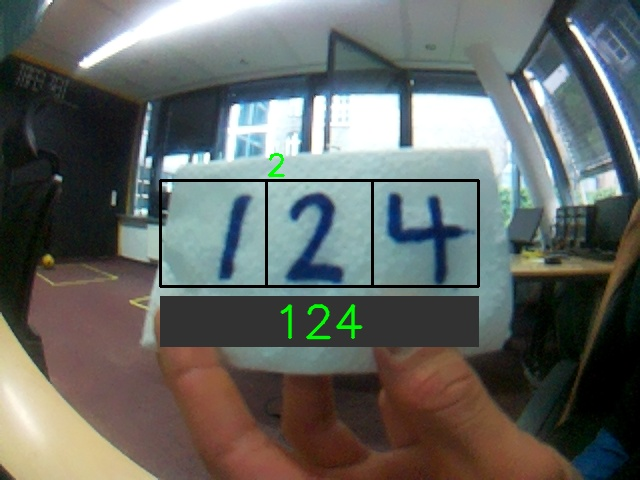

None

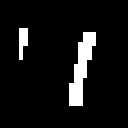

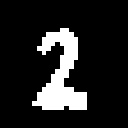

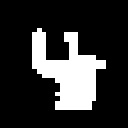

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [1]:
# Project based on the RaspRover image UGV_S10_240518.zip -> https://drive.google.com/file/d/1ELeIAsUIQ6ydEsc19Vssc6X0nz1myuJ_/view
# Modified and extended by Johny Roa Müller, 2025

# challange 3
from picamera2 import Picamera2
import cv2
import mediapipe as mp

import torch
import torch.nn as nn

from IPython.display import display, Image
import ipywidgets as widgets

from time import sleep
import threading
import queue

import numpy as np
from random import uniform
import imutils

import pyttsx3

from video_capture import FrameRecorder


from logger_configurator import setup_ugv_logger
from base_ctrl import BaseController
from audio_ctrl import play_speech

logger = setup_ugv_logger()

# Controller
#
#
import pygame

# Initialize PyGame
pygame.init()
pygame.joystick.init()

# Check if joystick is connected
if pygame.joystick.get_count() == 0:
    print("No joystick detected")
    exit()

joystick = pygame.joystick.Joystick(0)  # /dev/input/js0
joystick.init()

# raspberry pi version check.
def is_raspberry_pi5():
    with open('/proc/cpuinfo', 'r') as file:
        for line in file:
            if 'Model' in line:
                if 'Raspberry Pi 5' in line:
                    return True
                else:
                    return False


# MNIST-Modell
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


class UGVApp:
    def __init__(self, stop_button):
        self.stop_button = stop_button
        self.stop_event = threading.Event()
        self.pause_event = threading.Event()
        self.pause_event.set()
        self.stop_event_digit_recognition_loop = threading.Event()
        self.stop_event_line_tracking_loop = threading.Event()
        self.stop_event_detect_color_loop = threading.Event()
        
        # base Controller
        self.base = BaseController('/dev/ttyAMA0' if is_raspberry_pi5() else '/dev/serial0', 115200)

        # Camera + displays
        self.picam2 = Picamera2()
        self.picam2.configure(self.picam2.create_video_configuration(main={"format": 'XRGB8888', "size": (640, 480)}))
        self.frame = None

        # display handles for Jupyter
        self.digit_display_handle = display(None, display_id=True)
        self.border_display_handle = display(None, display_id=True)

        self.tensor_display_handles = [display(None, display_id=True) for _ in range(3)]

        # MediaPipe
        self.mpDraw = mp.solutions.drawing_utils
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(max_num_hands=1)

        # Color Params
        self.green_lower = np.array([50, 100, 50]) # ball detection
        self.green_upper = np.array([70, 255, 255]) # ball detection

        self.red_lower = np.array([160, 100, 100]) # ball detection
        self.red_upper = np.array([180, 255, 255]) # ball detection

        #self.blue_lower = np.array([100, 150, 50]) # ball detection red carpet
        #self.blue_upper = np.array([130, 255, 255]) # ball detection red carpet

        self.blue_lower = np.array([100, 150, 150]) # ball detection blue carpet
        self.blue_upper = np.array([130, 255, 255]) # ball detection blue carpet

        self.line_lower = np.array([25, 150, 70]) # line detection
        self.line_upper = np.array([42, 255, 255]) # line detection

        self.digit_lower_blue = np.array([95, 120, 40])
        self.digit_upper_blue = np.array([130, 255, 220])

        # Sampling lines for line tracking
        self.sampling_line_1 = 0.90
        self.sampling_line_2 = 0.99

        # Threads
        self.threads = []
        self.drive_threads = []
        
        self.digit_threads = []
        self.digit_check_threads = []

        # Flags
        self.driveFlag = False
        
        self.found_green_ball = False
        self.found_red_ball = False
        self.found_blue_ball = False   

        self.current_color = None

        self.digits_detected = False

        # load model
        self.model = SimpleNN()
        self.model.load_state_dict(torch.load('mnist_model.pth'))
        self.model.to("cpu")
        self.model.eval()

        # Digit-lists
        self.first_third = []
        self.second_third = []
        self.third_third = []
        self.digits_per_third = [self.first_third, self.second_third, self.third_third]

        # Digits
        self.first_value = 0
        self.second_value = 0
        self.third_value = 0
        self.needed_digits = self.needed_digits = int(str(self.first_value) + str(self.second_value) + str(self.third_value)) # hier zahl eintragen die erkannt werden muss

        # Recorder
        self.recorder_1 = FrameRecorder(filename="/home/FlottiRobotti/screencast_videos/challange_3/output_1.mp4", frame_rate=10, resolution=(640, 480))
        self.recorder_2 = FrameRecorder(filename="/home/FlottiRobotti/screencast_videos/challange_3/output_2.mp4", frame_rate=10, resolution=(28, 28))
        self.recorder_3 = FrameRecorder(filename="/home/FlottiRobotti/screencast_videos/challange_3/output_3.mp4", frame_rate=10, resolution=(28, 28))
        self.recorder_4 = FrameRecorder(filename="/home/FlottiRobotti/screencast_videos/challange_3/output_4.mp4", frame_rate=10, resolution=(28, 28))
        self.recorder_5 = FrameRecorder(filename="/home/FlottiRobotti/screencast_videos/challange_3/output_5.mp4", frame_rate=20, resolution=(640, 480))
        self.recorder_6 = FrameRecorder(filename="/home/FlottiRobotti/screencast_videos/challange_3/output_6.mp4", frame_rate=20, resolution=(640, 480))

        
    def start(self):
        # Recorder 
        self.recorder_1.start()
        self.recorder_2.start()
        self.recorder_3.start()
        self.recorder_4.start()
        self.recorder_5.start()
        self.recorder_6.start()
        
        logger.info('Starting Picamera2')
        self.picam2.start()
        self.stop_event.clear()
        self.stop_event_digit_recognition_loop.clear()
        self.stop_event_line_tracking_loop.clear()
        self.stop_event_detect_color_loop.clear()

        # Launch workers
        t1 = threading.Thread(target=self._camera_loop, daemon=True)
        t2 = threading.Thread(target=self._digit_recognition_loop, daemon=True)
        t3 = threading.Thread(target=self._line_tracking_loop, daemon=True)
        t4 = threading.Thread(target=self._detect_green_ball_loop, daemon=True)
        self.threads.extend([t1, t2, t3, t4])
        t1.start()
        t2.start()
        t3.start()
        t4.start()
        

    def stop(self):
        logger.info('Stopping app')
        self.stop_event.set()
        self.stop_event_digit_recognition_loop.set()
        self.stop_event_line_tracking_loop.set()
        self.stop_event_detect_color_loop.set()
        # stop camera
        try:
            self.picam2.close()
        except Exception:
            logger.exception('Error closing camera')
        # ensure base is stopped
        try:
            self.base.send_command({"T": 1, "L": 0, "R": 0})
        except Exception:
            logger.exception('Error sending stop to base')

    
    def _camera_loop(self):
        while not self.stop_event.is_set():
            self.frame = self.picam2.capture_array()

    
    def do_speech_thread(self, msg):
        threading.Thread(target=play_speech, args=(msg,), daemon=True).start()    

    
    # Digit-Extraktion (Tensor)
    def extract_digit(self, roi):
        if len(roi.shape) == 3:
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        roi = cv2.resize(roi, (20,20), interpolation=cv2.INTER_AREA)
        _, roi = cv2.threshold(roi, 127, 255, cv2.THRESH_BINARY)
        roi = cv2.bitwise_not(roi)
        square = np.zeros((28,28), dtype=np.uint8)
        x_offset = (28 - 20) // 2
        y_offset = (28 - 20) // 2
        square[y_offset:y_offset+20, x_offset:x_offset+20] = roi
        square = square.astype(np.float32) / 255.0
        tensor = torch.tensor(square, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        return tensor    
    

    def _digit_recognition_loop(self):
        while not self.stop_event_digit_recognition_loop.is_set():           
            if self.frame is None:
                logger.info("frame is none")
                sleep(0.05)
                continue
            # self.driveFlag = True # skip gesture
            # return True           # skip gesture    
            logger.info("digit recognition started")

            # setting needed number
            #
            #
            pygame.event.pump()  # Process events

            button_x = joystick.get_button(3)
            button_a = joystick.get_button(0)
            button_b = joystick.get_button(1)
            button_y = joystick.get_button(4)

            def set_digits():
                sleep(1)
                if button_x:
                    self.first_value += 1
                    self.do_speech_thread(self.first_value)
                    if self.first_value > 6:
                        self.first_value = 1
                if button_a:
                    self.second_value += 1
                    self.do_speech_thread(self.second_value)
                    if self.second_value > 6:
                        self.second_value = 1
                if button_b:
                    self.third_value += 1
                    self.do_speech_thread(self.third_value)
                    if self.third_value > 6:
                        self.third_value = 1

            def check_digits():
                if button_y:
                    sleep(1)
                    self.do_speech_thread("looking for")
                    sleep(1.5)
                    self.do_speech_thread(self.first_value)
                    sleep(1.5)
                    self.do_speech_thread(self.second_value)
                    sleep(1.5)
                    self.do_speech_thread(self.third_value)
                    sleep(1)


            if button_x or button_a or button_b:
                # check, if threads already exists
                active_threads = [t for t in self.digit_threads if t.is_alive()]
                if not active_threads:  # only start, when no active thread is there
                    digit_thread = threading.Thread(target=set_digits, daemon=True)
                    self.digit_threads.append(digit_thread)
                    digit_thread.start()

            if button_y:
                active_check_threads = [t for t in self.digit_check_threads if t.is_alive()]
                if not active_check_threads:
                    check_thread = threading.Thread(target=check_digits, daemon=True)
                    self.digit_check_threads.append(check_thread)
                    check_thread.start()

            
            # Update needed_digits dynamically
            self.needed_digits = int(f"{self.first_value}{self.second_value}{self.third_value}")
                
            
            
            height, width = self.frame.shape[:2]
    
            # Scan area centered: 50% width × 25% height
            scan_width = width // 2
            scan_height = height // 4
            x_min = (width - scan_width) // 2
            y_min = (height - scan_height) // 2
    
            # Square thirds
            square_size = min(scan_height, scan_width // 3)
            self.thirds = []
            for i in range(3):
                x0 = x_min + i * square_size
                x1 = x0 + square_size
                y0 = y_min
                y1 = y0 + square_size
                self.thirds.append((x0, y0, x1, y1))
    
            display_img = self.frame.copy()

    
            for i, (x0, y0, x1, y1) in enumerate(self.thirds):
                digit_roi = self.frame[y0:y1, x0:x1]
    
                # HSV-Farbfilter für Blau
                digit_roi_hsv = cv2.cvtColor(digit_roi, cv2.COLOR_BGR2HSV)
                mask_blue = cv2.inRange(digit_roi_hsv, self.digit_lower_blue, self.digit_upper_blue)
                blue_ratio = np.sum(mask_blue > 0) / mask_blue.size

    
                # Prüfen, ob genug Blau vorhanden ist
                if blue_ratio < 0.05:
                    logger.info(f"Too little blue: {blue_ratio*100:.1f}% in {i} list")
                    continue
    
                tensor = self.extract_digit(digit_roi)
    
                # Tensor → Bild für Anzeige
                img = tensor.squeeze(0).squeeze(0).numpy()
                img = (img * 255).astype(np.uint8)
                if i == 0:
                    self.recorder_2.push_frame(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
                elif i == 1:
                    self.recorder_3.push_frame(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
                elif i == 2:
                    self.recorder_4.push_frame(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))

                img = cv2.resize(img, (128,128), interpolation=cv2.INTER_NEAREST)
                _, img_jpeg = cv2.imencode('.jpeg', img)
                self.tensor_display_handles[i].update(Image(data=img_jpeg.tobytes()))
    
                # Digit vorhersagen
                with torch.no_grad():
                    outputs = self.model(tensor)
                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    confidence, pred = torch.max(probs, 1)
                    if confidence.item() > 0.7:
                        self.digits_per_third[i].append(pred.item())
                        cv2.rectangle(display_img, (x0, y0), (x1, y1), (0,255,0), 2)
                        cv2.putText(display_img, str(pred.item()), (x0, y0-5),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
                        logger.info(f"Predicted digit {i}: {pred.item()} (confidence: {confidence.item():.2f})")
    
            # Thirds frame for overview
            for x0, y0, x1, y1 in self.thirds:
                cv2.rectangle(display_img, (x0, y0), (x1, y1), (0,0,0), 2)
    
            # --- Result display --- #
    
            # Box-height and position
            box_height = 50
            box_y0 = y_min + square_size + 10  # some space to the thirds
            box_y1 = box_y0 + box_height
            box_x0 = x_min
            box_x1 = x_min + 3*square_size
            
            # rectangle for textbox
            cv2.rectangle(display_img, (box_x0, box_y0), (box_x1, box_y1), (50,50,50), -1)  # filled, darkgrey
            
            # text for prediction
            display_text = ''
            
            # check, is a third got 10 objects or more
            if any(len(self.third) >= 10 for self.third in self.digits_per_third):
                for self.third in self.digits_per_third:
                    if self.third:  # mindestens ein Wert vorhanden
                        # meistvorkommende Zahl des Drittels
                        most_common_num = max(set(self.third), key=self.third.count)
                        display_text += str(most_common_num)
                    else:
                        display_text += '_'  # Placeholder for empty third
            else:
                display_text = ''  # not enough data now
            
            # text in the box
            text_size = 1.5
            thickness = 2
            (text_width, text_height), _ = cv2.getTextSize(display_text, cv2.FONT_HERSHEY_SIMPLEX, text_size, thickness)
            text_x = box_x0 + (box_x1 - box_x0 - text_width) // 2
            text_y = box_y0 + (box_height + text_height) // 2
            cv2.putText(display_img, display_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), thickness, cv2.LINE_AA)
    
            # --- Result display --- #
            

    
    
            display_resized = cv2.resize(display_img, (640,480), interpolation=cv2.INTER_NEAREST)

            self.recorder_1.push_frame(display_img[:, :, :3])

            _, frame_jpeg = cv2.imencode('.jpeg', display_resized)
            self.digit_display_handle.update(Image(data=frame_jpeg.tobytes()))
    
            logger.info(self.digits_per_third[0])
            logger.info(self.digits_per_third[1])
            logger.info(self.digits_per_third[2])

            if display_text.isdigit() and self.needed_digits == int(display_text):
                if not self.digits_detected:
                    self.digits_detected = True
                    def stop_for_2_seconds():
                        self.do_speech_thread("digits detected")
                        sleep(2)
                        self.stop_event_digit_recognition_loop.set()
                        self.driveFlag = True
                    threading.Thread(target=stop_for_2_seconds, daemon=True).start()
                    #return True
                
    
            sleep(0.05)



    def _line_tracking_loop(self):     
        while not self.stop_event_line_tracking_loop.is_set():
            self.pause_event.wait() 
            if self.frame is None:
                sleep(0.05)
                continue      
            if self.driveFlag is False:
                sleep(0.05)
                continue  
            img = self.frame.copy()
            height, width = img.shape[:2]
            center_x, center_y = width // 2, height // 2
            # Image preprocessing, including color space conversion, Gaussian blur, color range filtering, etc.
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

            line_mask = cv2.inRange(hsv, self.line_lower, self.line_upper)  # Filter out target lines based on color range
            line_mask = cv2.erode(line_mask, None, iterations=1)  # Erosion operation to remove noise
            line_mask = cv2.dilate(line_mask, None, iterations=1)  # Dilation operation to enhance target lines

            # Detect target lines based on the positions of the upper and lower sampling lines, and calculate steering and speed control signals based on the detection results
            sampling_h1 = int(height * self.sampling_line_1)
            sampling_h2 = int(height * self.sampling_line_2)

            # get_sampling_1 = line_mask[sampling_h1]
            # get_sampling_2 = line_mask[sampling_h2]
            width = img.shape[1]
            start_x = int(width / 3)
            end_x = int(width * (2/3))
            
            get_sampling_1 = line_mask[sampling_h1][start_x:end_x]
            get_sampling_2 = line_mask[sampling_h2][start_x:end_x]

            # Calculate the width of the target line at the upper and lower sampling lines
            sampling_width_1 = np.sum(get_sampling_1 == 255)
            sampling_width_2 = np.sum(get_sampling_2 == 255)

            if sampling_width_1:
                sam_1 = True
            else:
                sam_1 = False
            if sampling_width_2:
                sam_2 = True
            else:
                sam_2 = False
    
            # Get the edge indices of the target line at the upper and lower sampling lines
            line_index_1 = np.where(get_sampling_1 == 255)
            line_index_2 = np.where(get_sampling_2 == 255)

            # If the target line is detected at the upper sampling line, calculate the center position of the target line
            if sam_1:
                sampling_1_left  = line_index_1[0][0]  # The leftmost index of the target line at the upper sampling line
                sampling_1_right = line_index_1[0][sampling_width_1 - 1]  # The rightmost index of the target line at the upper sampling line
                sampling_1_center= int((sampling_1_left + sampling_1_right) / 2)  # The index of the center of the target line at the upper sampling line
            # If the target line is detected at the lower sampling line, calculate the center position of the target line
            if sam_2:
                sampling_2_left  = line_index_2[0][0]
                sampling_2_right = line_index_2[0][sampling_width_2 - 1]
                sampling_2_center= int((sampling_2_left + sampling_2_right) / 2)
    
            # Initialize steering and speed control signals
            #base.send_command({"T":1,"L":-0.2,"R":-0.2})            line_slope = 0
            input_speed = 0
            input_turning = 0

            # If the target line is detected at both sampling lines, calculate the line slope and speed and steering control signals based on the slope and position of the target line
            if sam_1 and sam_2:
                def sam_1_and_sam_2():                
                    #self.base.send_command({"T":1,"L":-uniform(0.2, 0.4),"R":-uniform(0.2, 0.4)}) 
                    self.base.send_command({"T":1,"L":-0.2,"R":-uniform(0.3, 0.5)}) 
                    cv2.line(line_mask, (start_x, sampling_h1), (end_x, sampling_h2), (100, 0, 0), 4)
                    cv2.line(line_mask, (start_x, sampling_h2), (end_x, sampling_h1), (100, 0, 0), 4)  
                    sleep(1)

                thread = threading.Thread(target=sam_1_and_sam_2)
                thread.start()
                self.drive_threads.append(thread)
                #self.base.send_command({"T":1,"L":-uniform(0.0, 0.4),"R":-uniform(0.2, 0.4)}) 
                #cv2.line(line_mask, (start_x, sampling_h1), (end_x, sampling_h2), (100, 0, 0), 4)
                #cv2.line(line_mask, (start_x, sampling_h2), (end_x, sampling_h1), (100, 0, 0), 4)  
                #sleep(1)
                
            elif not sam_1 and sam_2: # If only the target line is detected at the lower sampling line
                def not_sam_1_and_sam_2():
                    #self.base.send_command({"T":1,"L":-uniform(0.2, 0.4),"R":-uniform(0.2, 0.4)}) 
                    self.base.send_command({"T":1,"L":-0.2,"R":-uniform(0.3, 0.5)}) 
                    cv2.line(line_mask, (start_x, sampling_h1), (end_x, sampling_h2), (100, 0, 0), 4)
                    cv2.line(line_mask, (start_x, sampling_h2), (end_x, sampling_h1), (100, 0, 0), 4)                    
                    sleep(1)

                thread = threading.Thread(target=not_sam_1_and_sam_2)
                thread.start()
                self.drive_threads.append(thread)
                #self.base.send_command({"T":1,"L":-uniform(0.0, 0.4),"R":-uniform(0.2, 0.4)}) 
                #cv2.line(line_mask, (start_x, sampling_h1), (end_x, sampling_h2), (100, 0, 0), 4)
                #cv2.line(line_mask, (start_x, sampling_h2), (end_x, sampling_h1), (100, 0, 0), 4)  
                #sleep(1)            

                
            elif sam_1 and not sam_2: # If only the target line is detected at the upper sampling line
                def sam_1_and_not_sam_2():
                    #self.base.send_command({"T":1,"L":-uniform(0.0, 0.4),"R":-uniform(0.0, 0.4)}) 
                    self.base.send_command({"T":1,"L":-0.2,"R":-uniform(0.3, 0.5)}) 
                    cv2.line(line_mask, (start_x, sampling_h1), (end_x, sampling_h2), (100, 0, 0), 4)
                    cv2.line(line_mask, (start_x, sampling_h2), (end_x, sampling_h1), (100, 0, 0), 4)                    
                    sleep(1) 
                    
                thread = threading.Thread(target=sam_1_and_not_sam_2)
                thread.start()
                self.drive_threads.append(thread)
                    #self.base.send_command({"T":1,"L":-uniform(0.4, 0.0),"R":-uniform(0.4, 0.0)}) 
                    #cv2.line(line_mask, (start_x, sampling_h1), (end_x, sampling_h2), (100, 0, 0), 4)
                    #cv2.line(line_mask, (start_x, sampling_h2), (end_x, sampling_h1), (100, 0, 0), 4)                    
                    #sleep(1)             

                
            else: # If no target line is detected at both sampling lines
                #base.send_command({"T":1,"L":0.2,"R":0.3})
                self.drive_threads = [t for t in self.drive_threads if t.is_alive()]
                if not any(t.is_alive() for t in self.drive_threads):
                    # self.base.send_command({"T":1,"L":uniform(0.2, 0.4),"R":uniform(0.2, 0.4)}) 
                    self.base.send_command({"T":1,"L":0.2,"R":0.2}) 
                    cv2.line(line_mask, (start_x, sampling_h1), (end_x, sampling_h2), (0, 0, 0), 4)
                    cv2.line(line_mask, (start_x, sampling_h2), (end_x, sampling_h1), (0, 0, 0), 4)
                
    
            # base.base_json_ctrl({"T":13,"X":input_speed,"Z":input_turning})
            # base.send_command({"T":1,"L":0.2,"R":0.2})
    
            cv2.putText(line_mask, f'X: {input_speed:.2f}, Z: {input_turning:.2f}', (center_x+50, center_y+0), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            # Visualization operations, including drawing lines at sampling line positions, marking sampling results, and displaying steering and speed control signals
            # cv2.line(line_mask, (0, sampling_h1), (img.shape[1], sampling_h1), (255, 0, 0), 4) # original code
            # cv2.line(line_mask, (0, sampling_h2), (img.shape[1], sampling_h2), (255, 0, 0), 4) # original code
            # horizontal lines
            cv2.line(line_mask, (start_x, sampling_h1), (end_x, sampling_h1), (255, 0, 0), 4)
            cv2.line(line_mask, (start_x, sampling_h2), (end_x, sampling_h2), (255, 0, 0), 4)
            # vertikal lines
            cv2.line(line_mask, (start_x, sampling_h1), (start_x, sampling_h2), (255, 0, 0), 4)
            cv2.line(line_mask, (end_x, sampling_h1), (end_x, sampling_h2), (255, 0, 0), 4)     
    
            # cv2.line(line_mask, (start_x, sampling_h1), (end_x, sampling_h2), (100, 0, 0), 4) # crosshair comp
            # cv2.line(line_mask, (start_x, sampling_h2), (end_x, sampling_h1), (100, 0, 0), 4) # crosshair comp
            # shorting the line
            #> syntax cv2.line(image, start_point, end_point, color, thickness)
            # cv2.line(line_mask, (int(img.shape[1] / 3), sampling_h1), (int(img.shape[1] - img.shape[1] / 3), sampling_h1), (255, 0, 0), 4)
            # cv2.line(line_mask, (int(img.shape[1] / 3), sampling_h2), (int(img.shape[1] - img.shape[1] / 3), sampling_h2), (255, 0, 0), 4)
            # redundant, becausei should use the parameters who set the sampling values
            
            if sam_1:
                # Draw green marker lines at both ends of the target line at the upper sampling line
                cv2.line(line_mask, (sampling_1_left, sampling_h1+20), (sampling_1_left, sampling_h1-20), (0, 255, 0), 2)
                cv2.line(line_mask, (sampling_1_right, sampling_h1+20), (sampling_1_right, sampling_h1-20), (0, 255, 0), 2)
            if sam_2:
                # Draw green marker lines at both ends of the target line at the lower sampling line
                cv2.line(line_mask, (sampling_2_left, sampling_h2+20), (sampling_2_left, sampling_h2-20), (0, 255, 0), 2)
                cv2.line(line_mask, (sampling_2_right, sampling_h2+20), (sampling_2_right, sampling_h2-20), (0, 255, 0), 2)
            if sam_1 and sam_2:
                # If the target line is detected at both upper and lower sampling lines, draw a red line from the center of the upper sampling line to the center of the lower sampling line
                cv2.line(line_mask, (sampling_1_center, sampling_h1), (sampling_2_center, sampling_h2), (255, 0, 0), 2)


            # img_resized = cv2.resize(img, (img.shape[1]*2, img.shape[0]*2))
            # _, frame_jpeg = cv2.imencode('.jpeg', img_resized)

            self.recorder_5.push_frame(cv2.cvtColor(line_mask, cv2.COLOR_GRAY2BGR))

            _, frame_jpeg = cv2.imencode('.jpeg', line_mask)
            self.border_display_handle.update(Image(data=frame_jpeg.tobytes()))


    def _detect_green_ball_loop(self):
        while not self.stop_event_detect_color_loop.is_set():
            if not self.driveFlag:
                sleep(0.05)
                continue
            logger.info("ball detection started")
            if not self.found_red_ball:
                color_lower = self.red_lower
                color_upper = self.red_upper
                found_signal = "red ball"
                self.current_color = "red"
                logger.info("searching for red ball")   
            elif not self.found_green_ball:
                color_lower = self.green_lower
                color_upper = self.green_upper
                found_signal = "green ball"
                self.current_color = "green"
                logger.info("searching for green ball")  
            elif not self.found_blue_ball:
                color_lower = self.blue_lower
                color_upper = self.blue_upper
                found_signal = "blue ball"
                self.current_color = "blue"
                logger.info("searching for blue ball")
                
    
            logger.info(color_lower)
            logger.info(color_upper)
            
            min_radius = 12  # Define the minimum radius for detecting objects   
        
            frame_width = 640
            frame_height = 480
            bottom_tenth_start = int(frame_height * 0.50) # bottom_tenth_start = int(frame_height * 0.65)
            bottom_tenth_end = frame_height
            x_min = 0 # frame_width // 4        
            x_max = frame_width # * 3 // 4    

            # Center des Rechtecks
            center_x_rect = (x_min + x_max) // 2
            center_y_rect = (bottom_tenth_start + bottom_tenth_end) // 2

            frame = self.frame.copy()
            
            blurred = cv2.GaussianBlur(frame, (11, 11), 0)  # Apply Gaussian blur to the image to remove noise
            hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)  # Convert the image from BGR to HSV color space
            mask = cv2.inRange(hsv, color_lower, color_upper)  # Create a mask to retain only objects within a specific color range
            mask = cv2.erode(mask, None, iterations=2)  # Apply erosion to the mask to remove small white spots
            mask = cv2.dilate(mask, None, iterations=2)  # Apply dilation to the mask to highlight the object regions
    
            # Find contours in the mask
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)  # Extract contours
            center = None  # Initialize the center of the object

            if len(cnts) > 0:
                c = max(cnts, key=cv2.contourArea)
                ((x_ball_center, y_ball_center), radius) = cv2.minEnclosingCircle(c) # x and y coordinates are the center of the ball, radius the radius of the ball
                if radius > min_radius:
                    # Kreis zeichnen
                    cv2.circle(frame, (int(x_ball_center), int(y_ball_center)), int(radius), (128, 255, 255), 2)

                    '''
                    
                    # Bereich visuell markieren
                    cv2.rectangle(frame,
                                  (x_min, bottom_tenth_start),
                                  (x_max, frame_height),
                                  (0, 255, 0), 2)

                    
                    # Center-Markierung (dunkleres Grün)
                    #cv2.circle(frame, (center_x, center_y), 5, (0, 128, 0), -1)
                    #cv2.line(frame, (center_x, center_y), 5, (0, 128, 0), -1)

            
                    # Mittellinie in der Mitte des Rechtecks (vertikal 40 Pixel)
                    line_length = 40
                    cv2.line(frame,
                             (center_x_rect, center_y_rect - line_length // 2),
                             (center_x_rect, center_y_rect + line_length // 2),
                             (0, 255, 0), 2)  # hellgrün     
                    

                    rect_line_length = 40
                    rect_width = 40  # Breite des Rechtecks
                    
                    # Obere linke Ecke des Rechtecks
                    top_left = (center_x_rect - rect_width // 2, center_y_rect - rect_line_length // 2)
                    # Untere rechte Ecke des Rechtecks
                    bottom_right = (center_x_rect + rect_width // 2, center_y_rect + rect_line_length // 2)
                    

                    # Rechteck zeichnen (gefüllt)
                    cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)  # 2 = hohl
                    
                    '''
                    
                    # colors
                    grey_color = (128, 128, 128)
                    blue_color = (255, 0, 0)
                    green_color = (0, 255, 0)
                    red_color = (0, 0, 255)
                    
                    # if self.current_color == "blue"
                    # upper border line and color of it
                    #
                    #
                    if y_ball_center < bottom_tenth_start:
                        color_to_use = grey_color
                    elif y_ball_center > bottom_tenth_start and self.current_color == "blue":
                        color_to_use = blue_color
                    elif y_ball_center > bottom_tenth_start and self.current_color == "red":
                        color_to_use = red_color
                    elif y_ball_center > bottom_tenth_start and self.current_color == "green":
                        color_to_use = green_color

                    cv2.line(frame,
                        (x_min, bottom_tenth_start),
                        (x_max, bottom_tenth_start),
                        color_to_use, 2)  # hellgrün    


                    # Center line in the middle of the rectangle (vertical, 40 pixels) /// cv2.line(image, (x_start, y_start), (x_end, y_end), color, thickness)
                    #
                    #
                    line_length = 40
                    cv2.line(frame,
                             (center_x_rect, center_y_rect - line_length // 2),
                             (center_x_rect, center_y_rect + line_length // 2),
                             color_to_use, 2)  # hellgrün   


                    
                    # Sight lines /// cv2.line(image, (x_start, y_start), (x_end, y_end), color, thickness)
                    # 
                    #
                    for i in range(4):   
                        # Calculate line coordinates
                        # right up
                        start_ru = (frame_width - (frame_width // 2 // 5) * i,
                                    bottom_tenth_start + ((bottom_tenth_end - bottom_tenth_start) // 5) * i)
                        end_ru = (center_x_rect + 20 + 40 * i, center_y_rect)

                        # left up
                        start_lu = (0 + (frame_width // 2 // 5) * i,
                                    bottom_tenth_start + ((bottom_tenth_end - bottom_tenth_start) // 5) * i)
                        end_lu = (center_x_rect - 20 - 40 * i, center_y_rect)

                        # right down
                        start_rd = (frame_width - (frame_width // 2 // 5) * i,
                                    bottom_tenth_end - ((bottom_tenth_end - bottom_tenth_start) // 5) * i)
                        end_rd = (center_x_rect + 20 + 40 * i, center_y_rect)

                        # left down
                        start_ld = (0 + (frame_width // 2 // 5) * i,
                                    bottom_tenth_end - ((bottom_tenth_end - bottom_tenth_start) // 5) * i)
                        end_ld = (center_x_rect - 20 - 40 * i, center_y_rect)
                    
                        # basic colors
                        color_ru = color_lu = color_rd = color_ld = (128, 128, 128)

                        if y_ball_center >= bottom_tenth_start and x_min <= x_ball_center <= x_max:
                    
                            # Check if the ball is near a line (±20 pixels on X or Y axis)
                            ru_hit = abs(x_ball_center - end_ru[0]) < 20 or abs(y_ball_center - end_ru[1]) < 20
                            lu_hit = abs(x_ball_center - end_lu[0]) < 20 or abs(y_ball_center - end_lu[1]) < 20
                            rd_hit = abs(x_ball_center - end_rd[0]) < 20 or abs(y_ball_center - end_rd[1]) < 20
                            ld_hit = abs(x_ball_center - end_ld[0]) < 20 or abs(y_ball_center - end_ld[1]) < 20
                        
                            # When a line is hit, it lights up along with its opposite line
                            if ru_hit or lu_hit:
                                color_ru = color_to_use
                                color_lu = color_to_use
                            if rd_hit or ld_hit:
                                color_rd = color_to_use
                                color_ld = color_to_use
                    
                        # draw lines
                        cv2.line(frame, start_ru, end_ru, color_ru, 2)
                        cv2.line(frame, start_lu, end_lu, color_lu, 2)
                        cv2.line(frame, start_rd, end_rd, color_rd, 2)
                        cv2.line(frame, start_ld, end_ld, color_ld, 2)



                    # centering area
                    #
                    #
                    rect_line_length = 40
                    rect_width = 40  # Width of the rectangle
                    
                    # Top-left corner of the rectangle
                    top_left = (center_x_rect - rect_width // 2, center_y_rect - rect_line_length // 2)
                    # Bottom-right corner of the rectangle
                    bottom_right = (center_x_rect + rect_width // 2, center_y_rect + rect_line_length // 2)
                    
                    
                    
                    # check if ball is in big rectangle
                    #
                    #
                    def stop_for_2_seconds():
                        sleep(2)
                        self.pause_event.set()
                    
                    if y_ball_center >= bottom_tenth_start and x_min <= x_ball_center <= x_max:
                        self.pause_event.clear()
                        #self.stop_event_line_tracking_loop.set()
                        #self.base.send_command({"T":1,"L":0,"R":0})
                        # check if ball is in small rectangle
                        if top_left[0] <= x_ball_center <= bottom_right[0] and top_left[1] <= y_ball_center <= bottom_right[1]:
                            if not self.found_red_ball:
                                self.base.send_command({"T":1,"L":0,"R":0})
                                self.found_red_ball = True    
                                self.do_speech_thread("red ball")
                                logger.info("-------------------->found red ball")   
                                threading.Thread(target=stop_for_2_seconds, daemon=True).start()
                                continue
                            elif not self.found_green_ball:
                                self.base.send_command({"T":1,"L":0,"R":0})
                                self.found_green_ball = True  
                                self.do_speech_thread("green ball")
                                logger.info("-------------------->found green ball")
                                threading.Thread(target=stop_for_2_seconds, daemon=True).start()
                                continue
                            elif not self.found_blue_ball:
                                self.base.send_command({"T":1,"L":0,"R":0})
                                self.found_blue_ball = True  
                                self.do_speech_thread("blue ball")
                                sleep(2)
                                logger.info("-------------------->found blue ball")
                                self.stop_event_line_tracking_loop.set()
                            # nur bewegen, wenn noch nicht beide Bälle gefunden sind
                        if not (self.found_red_ball and self.found_blue_ball and self.found_blue_ball):
                            # backwards
                            if y_ball_center > center_y_rect:
                                self.base.send_command({"T":1,"L":-0.15,"R":-0.15})
                            # Soft left
                            if x_ball_center < center_x_rect and not y_ball_center > center_y_rect:
                                self.base.send_command({"T":1,"L":0,"R":0.15})
                            # Soft right
                            if x_ball_center > center_x_rect and not y_ball_center > center_y_rect:
                                self.base.send_command({"T":1,"L":0.15,"R":0})
                              
                            #return
                            #sleep(0.2)
                            #sleep(120)
                            #os._exit(0)
                            # trigger_action()
                            #return True
                    
            self.recorder_6.push_frame(frame[:, :, :3])
                    
            _, frame_jpeg = cv2.imencode('.jpeg', frame)
            self.digit_display_handle.update(Image(data=frame_jpeg.tobytes()))
              


# Create UI controls and start
stopButton = widgets.ToggleButton(value=False, description='Stop', button_style='danger', icon='square')
display(stopButton)
app = UGVApp(stopButton)
app.start()


# Watch the button in background and stop app when toggled
def monitor_button(btn):
    while True:
        if btn.value:
            app.recorder_1.stop()
            app.recorder_2.stop()
            app.recorder_3.stop()
            app.recorder_4.stop()
            app.recorder_5.stop()
            app.recorder_6.stop()
            app.stop()
            break
        sleep(0.2)

threading.Thread(target=monitor_button, args=(stopButton,), daemon=True).start()
 








